# 모듈

In [1]:
# Data Preprocessing 
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, time
import re
import time
from tqdm import tqdm
import shap

# scikit-learn, Scipy & Machine Learning
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import norm
import xgboost
import lightgbm as lgb

# Tensorflow for Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Visualization
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

%matplotlib inline

# matplotlib 한글 깨짐 해결
rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
2023-09-27 04:08:11.545765: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 데이터 불러오기

In [2]:
data = pd.read_csv('../final_new_grouping.csv')
data.head()

,key,new_code,age,gender,tran_date,tran_time,play_date,play_st_time,seat,price,...,cancel_rate,paid_rate,pre_rate,capa_rate,howfastyoubuy,50%,newseatgen_mean,newseatloc_mean,newfloorloc_mean,seat_grouping
0,0,435,50.0,F,2022-01-14,15:12,2022-02-04,20:00,3층 BOX9 10,10000,...,0.172237,0.996144,0.0,0.257086,-21,-19.0,-7.866337,-10.000000,-10.752066,orange
1,1,449,50.0,M,2022-02-06,16:15,2022-03-02,19:30,1층 B블록12열 7,180000,...,0.244957,0.968300,0.0,0.522954,-24,-50.0,-24.009132,-31.433420,-27.927313,red
2,2,31,30.0,F,2018-11-24,11:45,2019-03-23,20:00,1층 A블록2열 1,144000,...,0.167689,0.991820,0.0,0.649900,-119,-123.0,-70.903101,-71.093434,-69.510129,yellow
3,4,100,NaN,NaN,2019-06-13,09:54,2019-07-23,20:00,2층 D블록8열 4,0,...,0.004285,0.028388,0.0,0.742116,-40,-40.0,-34.708885,-30.234501,-29.536585,green
4,5,99,NaN,F,2019-07-03,09:08,2019-07-21,17:00,1층 C블록17열 3,75000,...,0.044788,0.348534,0.0,0.525773,-18,-6.0,-5.536585,-5.812500,-5.581522,blue


# 데이터 전처리

In [3]:
# nan값 삭제
data.dropna(inplace=True)
# price=0 제외
data = data[data['price'] != 0]

In [4]:
# 변수추가
# 코로나19 (20200120~20211231)까지
def covid19(x):
    if '2020-01-20' <= x <= '20211231':
        return 1
    else:
        return 0
    
data['covid19'] = data['play_date'].apply(lambda x : covid19(x))

In [5]:
# 우리모형에 사용할 변수 선택
cols = ['new_code','price', 'age', 'gender', 'genre', 'running_time', 'season', 'performance_time_slot', 'cancel_rate', 'paid_rate', 'pre_rate', 'capa_rate', 'weekday_or_weekend', 'covid19',
        'general', 'sac', 'noble', 'blue', 'green', 'gold', 'all_mem_cnt', 'inv2_paymem_cnt', 'involvement',
        'seat_floor', 'seat_loc', 'seat_grouping', 'discount_cat', 'discount_rate']

# 참고모형에 사용한 변수 목록
#cols = ['new_code','price', 'age', 'gender', 'genre', 'running_time', 'weekday_or_weekend', 'covid19', 'seat_floor', 'seat_loc', 'seat_grouping']

df = data[cols]

In [6]:
# 원-핫 인코딩
categorical_columns = ['genre', 'season', 'performance_time_slot', 'seat_grouping', 'seat_floor', 'seat_loc', 'age', 'discount_cat']
#categorical_columns = ['genre', 'seat_grouping', 'seat_floor', 'seat_loc', 'age']

df_encoded = pd.get_dummies(df, columns=categorical_columns, dtype=int)

# 라벨 인코딩
# 라벨 인코더 생성
label_encoder = LabelEncoder()
columns_to_encode = ['gender', 'weekday_or_weekend'] # gender, weekday_or_weekend 컬럼 라벨인코딩

label_encoders = {}

# 각 열에 대해 LabelEncoder 적용
for column in columns_to_encode:
    encoder = LabelEncoder()
    df_encoded[column] = encoder.fit_transform(df[column])
    label_encoders[column] = encoder
    
# 저장된 라벨 인코딩 정보 확인
for column, encoder in label_encoders.items():
    print(f"Column '{column}' encoding:")
    for idx, label in enumerate(encoder.classes_):
        print(f"{label} -> {idx}")
    print("-----------------------")

# 종속변수 로그변환    
df_encoded['price'] = np.log(df_encoded['price'])


Column 'gender' encoding:
F -> 0
M -> 1
-----------------------
Column 'weekday_or_weekend' encoding:
weekday -> 0
weekend -> 1
-----------------------


# 가격모델 ML

## Train-Test Split

In [7]:

# Create an instance of GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Splitting the data based on `new_code` to ensure the same performance doesn't appear in both train and test sets
train_idx, test_idx = next(gss.split(df_encoded, groups=df_encoded['new_code']))

# Using the indices to get the train and test data
train_data_grouped = df_encoded.iloc[train_idx]
test_data_grouped = df_encoded.iloc[test_idx]

# Checking the number of unique `new_code` in train and test datasets
train_unique_codes_grouped = train_data_grouped['new_code'].nunique()
test_unique_codes_grouped = test_data_grouped['new_code'].nunique()

print(train_unique_codes_grouped)
print(test_unique_codes_grouped)

train_data_grouped = train_data_grouped.drop('new_code', axis=1)
test_data_grouped = test_data_grouped.drop('new_code', axis=1)

x_train = train_data_grouped.drop('price', axis=1)
x_test = test_data_grouped.drop('price', axis=1)
y_train = train_data_grouped['price']
y_test = test_data_grouped['price']

532
134


## 1. 다중선형회귀

In [8]:
mlr = LinearRegression()
mlr.fit(x_train, y_train)

# 예측
predictions = mlr.predict(x_test)


# 잔차 계산
residuals = y_test - predictions

# 잔차의 표준편차
sigma = np.std(residuals)

# 로그 우도 계산
logL = np.sum(norm.logpdf(residuals, loc=0, scale=sigma))

# 파라미터 수 (계수 수 + 절편)
k = len(mlr.coef_) + 1

# 샘플 수
n = len(y_test)

# AIC와 BIC 계산
AIC = 2*k - 2*logL
BIC = k*np.log(n) - 2*logL


# 로그 변환된 값을 원래 스케일로 변환
original_y_test = np.exp(y_test)
original_predictions = np.exp(predictions)

# 평가 지표 출력
explained_var = explained_variance_score(original_predictions, original_y_test)
mse = mean_squared_error(original_predictions, original_y_test)

print(f"Training R^2 Score: {mlr.score(x_train, y_train):.4f}")
print(f"Explained Variance Score: {explained_var:.4f}")
print(f"Rooted Mean Squared Error: {np.sqrt(mse):.4f}")
print(f"AIC: {AIC:.4f}")
print(f"BIC: {BIC:.4f}")

Training R^2 Score: 0.4852
Explained Variance Score: -0.4531
Rooted Mean Squared Error: 39446.5079
AIC: 116360.3808
BIC: 116944.6722


### 다중선형회귀 성능 시각화

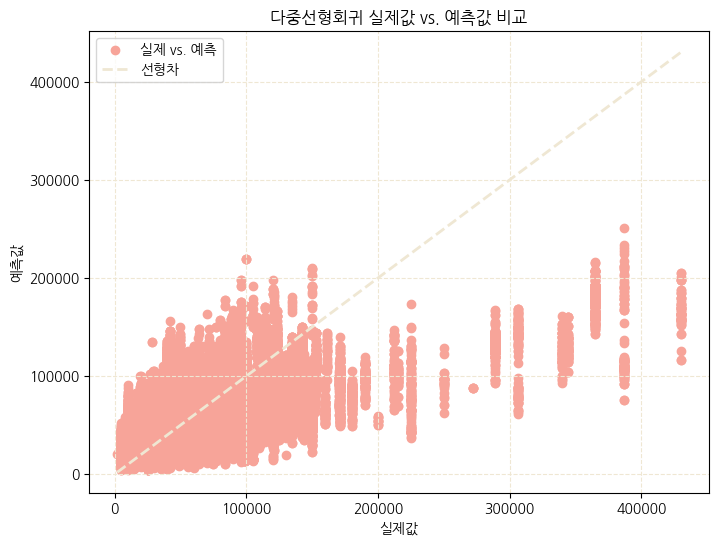

In [9]:
# 실제 값과 예측 값의 산점도

# 예측값 (y_pred)와 실제값 (y_true) 설정
y_true = original_y_test  # 실제값
y_pred = original_predictions # 예측값

# 예측값과 실제값 비교 그래프를 그립니다.
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, c='#F7A499', marker='o', label='실제 vs. 예측')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('다중선형회귀 실제값 vs. 예측값 비교')
plt.legend(loc='upper left')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], linestyle='--', color='#EFE7D3', linewidth=2, label='선형차')
plt.legend(loc='upper left')
plt.grid(True,linestyle='--', color='#EFE7D3')
plt.show()

## 2. XGBoost

In [10]:
# XGBoost 모델 설정 및 학습
xgb_model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7, tree_method='gpu_hist')
xgb_model.fit(x_train, y_train)

# 예측 및 평가
predictions = xgb_model.predict(x_test)

# 잔차 계산
residuals = y_test - predictions

# 잔차의 표준편차
sigma = np.std(residuals)

# 로그 우도 계산
logL = np.sum(norm.logpdf(residuals, loc=0, scale=sigma))

# 파라미터 수 (여기서는 트리의 수로 간주)
k = xgb_model.n_estimators

# 샘플 수
n = len(y_test)

# AIC와 BIC 계산
AIC = 2*k - 2*logL
BIC = k*np.log(n) - 2*logL

# 로그 변환된 값을 원래 스케일로 변환
original_y_test = np.exp(y_test)
original_predictions = np.exp(predictions)

# 평가 지표 출력
explained_var = explained_variance_score(original_predictions, original_y_test)
mse = mean_squared_error(original_predictions, original_y_test)

print('---------------------------------------------------------------')
print(f"Training R^2 Score: {xgb_model.score(x_train, y_train):.4f}")
print(f"Explained Variance Score: {explained_var:.4f}")
print(f"Rooted Mean Squared Error: {np.sqrt(mse):.4f}")
print(f"AIC: {AIC:.4f}")
print(f"BIC: {BIC:.4f}")

[04:08:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[04:08:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[04:08:32] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



---------------------------------------------------------------
Training R^2 Score: 0.9131
Explained Variance Score: 0.2504
Rooted Mean Squared Error: 31376.9992
AIC: 86148.0764
BIC: 87046.9863


### XGBoost 성능 시각화

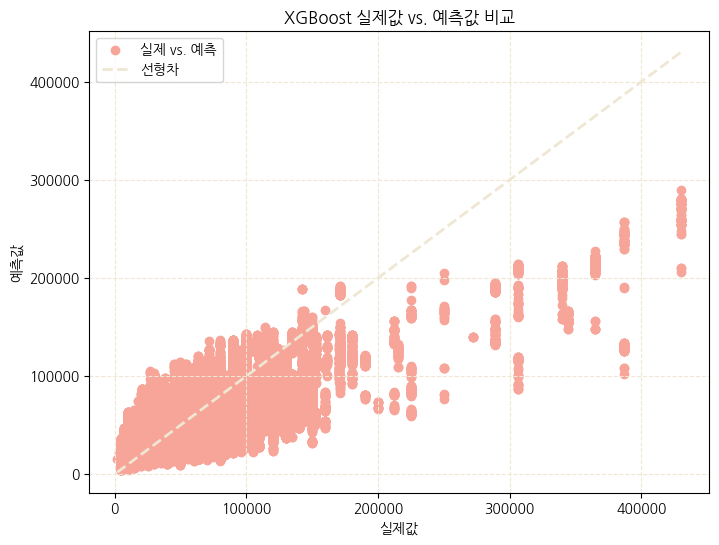

In [11]:
# 실제 값과 예측 값의 산점도

# 예측값 (y_pred)와 실제값 (y_true) 설정
y_true = original_y_test  # 실제값
y_pred = original_predictions # 예측값

# 예측값과 실제값 비교 그래프를 그립니다.
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, c='#F7A499', marker='o', label='실제 vs. 예측')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('XGBoost 실제값 vs. 예측값 비교')
plt.legend(loc='upper left')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], linestyle='--', color='#EFE7D3', linewidth=2, label='선형차')
plt.legend(loc='upper left')
plt.grid(True,linestyle='--', color='#EFE7D3')
plt.show()


### XGBoost Feature Importance

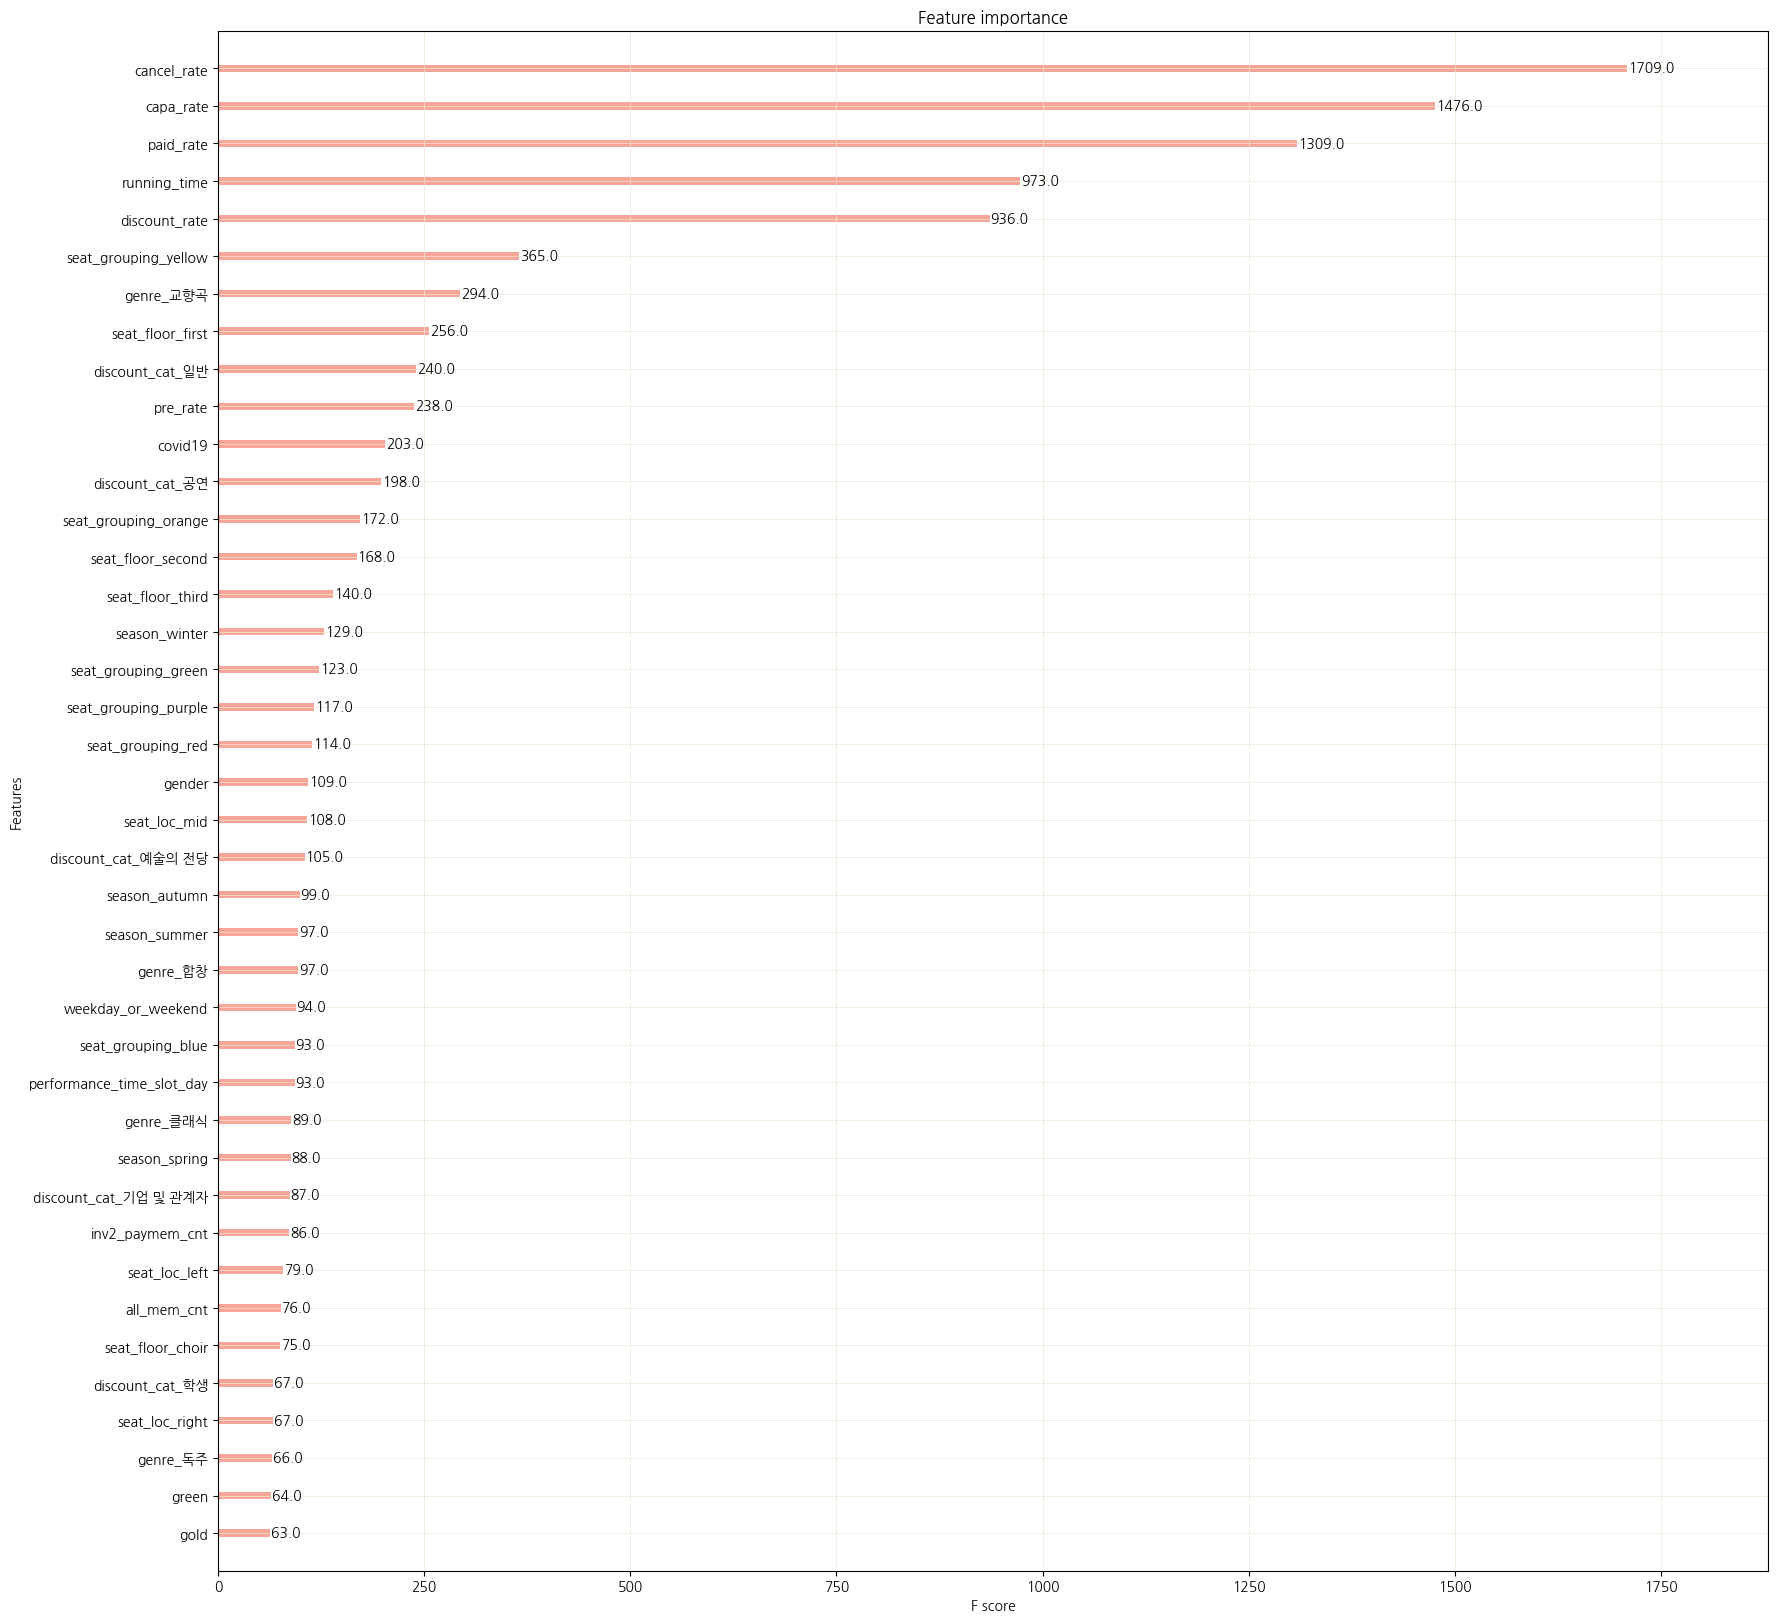

In [12]:
# 그래프 크기 조절 및 DPI 설정
plt.rcParams['figure.figsize'] = [20, 20]  # 원하는 크기로 조절

# 특성 중요도 그래프 그리기
ax = xgboost.plot_importance(xgb_model, max_num_features=40, color='#F7A499')

# 격자 색상 변경

ax.grid(True, linestyle='-', linewidth=0.5, color='#EFE7D3')

# 그래프 출력
plt.show()

### XGBoost SHAP Value

[04:08:43] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[04:08:44] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


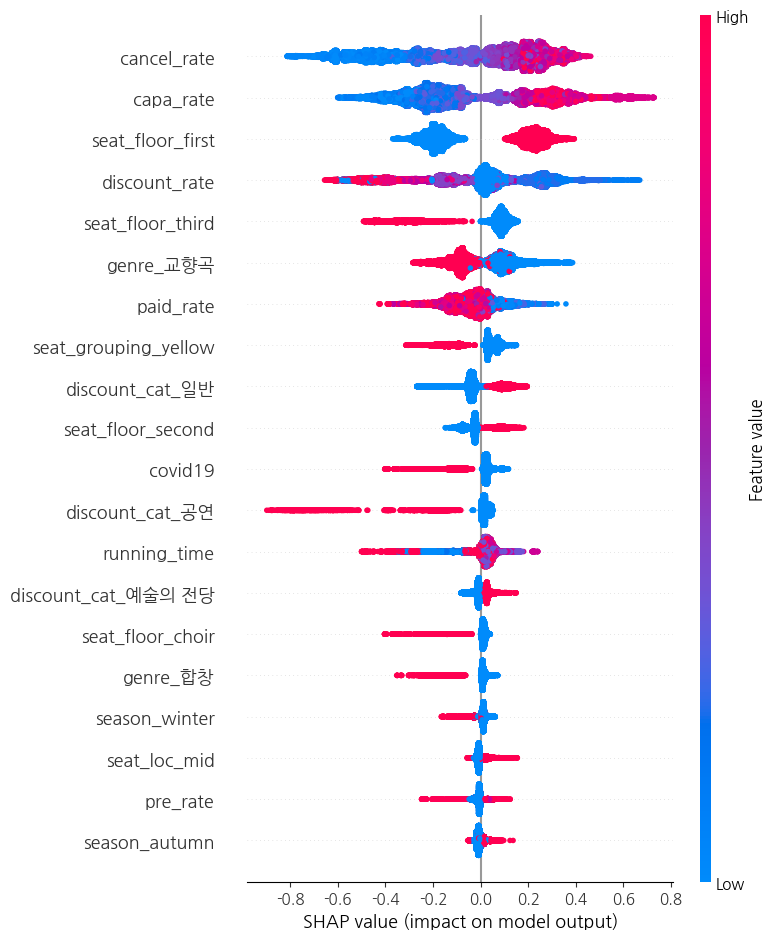

In [13]:
# SHAP explainer 객체 생성
explainer = shap.Explainer(xgb_model)

# SHAP values 계산
shap_values = explainer.shap_values(x_test)

# SHAP summary plot
shap.summary_plot(shap_values, x_test)

# 특정 인스턴스에 대한 SHAP force plot도 확인 가능
# 예를 들어, 첫 번째 테스트 인스턴스에 대해
shap.force_plot(explainer.expected_value, shap_values[0,:], x_test.iloc[0,:])

## 3. Random Forest

In [14]:
# RandomForestRegressor 모델 설정 및 학습
rf = RandomForestRegressor()
rf.fit(x_train, y_train)

# 예측
predictions = rf.predict(x_test)

# 잔차 계산
residuals = y_test - predictions

# 잔차의 표준편차
sigma = np.std(residuals)

# 로그 우도 계산
logL = np.sum(norm.logpdf(residuals, loc=0, scale=sigma))

# 파라미터 수 (여기서는 트리의 리프 노드 수의 평균 * 트리의 수로 계산)
avg_num_leaves = sum([estimator.get_n_leaves() for estimator in rf.estimators_]) / rf.n_estimators
k = rf.n_estimators * avg_num_leaves

# 샘플 수
n = len(y_test)

# AIC 및 BIC 계산
AIC = 2*k - 2*logL
BIC = k*np.log(n) - 2*logL

# 로그 변환된 값을 원래 스케일로 변환
original_y_test = np.exp(y_test)
original_predictions = np.exp(predictions)

# 평가 지표 출력
explained_var = explained_variance_score(original_predictions, original_y_test)
mse = mean_squared_error(original_predictions, original_y_test)

print(f"Training R^2 Score: {rf.score(x_train, y_train):.4f}")
print(f"Explained Variance Score: {explained_var:.4f}")
print(f"Rooted Mean Squared Error: {np.sqrt(mse):.4f}")
print(f"AIC: {AIC:.4f}")
print(f"BIC: {BIC:.4f}")


Training R^2 Score: 0.9894
Explained Variance Score: 0.6072
Rooted Mean Squared Error: 30808.8849
AIC: 8780676.5553
BIC: 47766596.8044


### RandomForest 성능 시각화

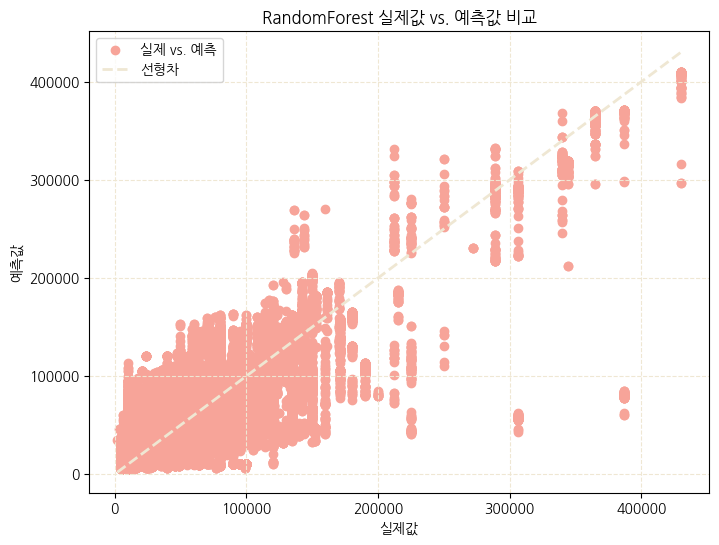

In [15]:
# 실제 값과 예측 값의 산점도

# 예측값 (y_pred)와 실제값 (y_true) 설정
y_true = original_y_test  # 실제값
y_pred = original_predictions # 예측값

# 예측값과 실제값 비교 그래프를 그립니다.
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, c='#F7A499', marker='o', label='실제 vs. 예측')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('RandomForest 실제값 vs. 예측값 비교')
plt.legend(loc='upper left')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], linestyle='--', color='#EFE7D3', linewidth=2, label='선형차')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', color='#EFE7D3')
plt.show()

### RandomForest Feature Importance

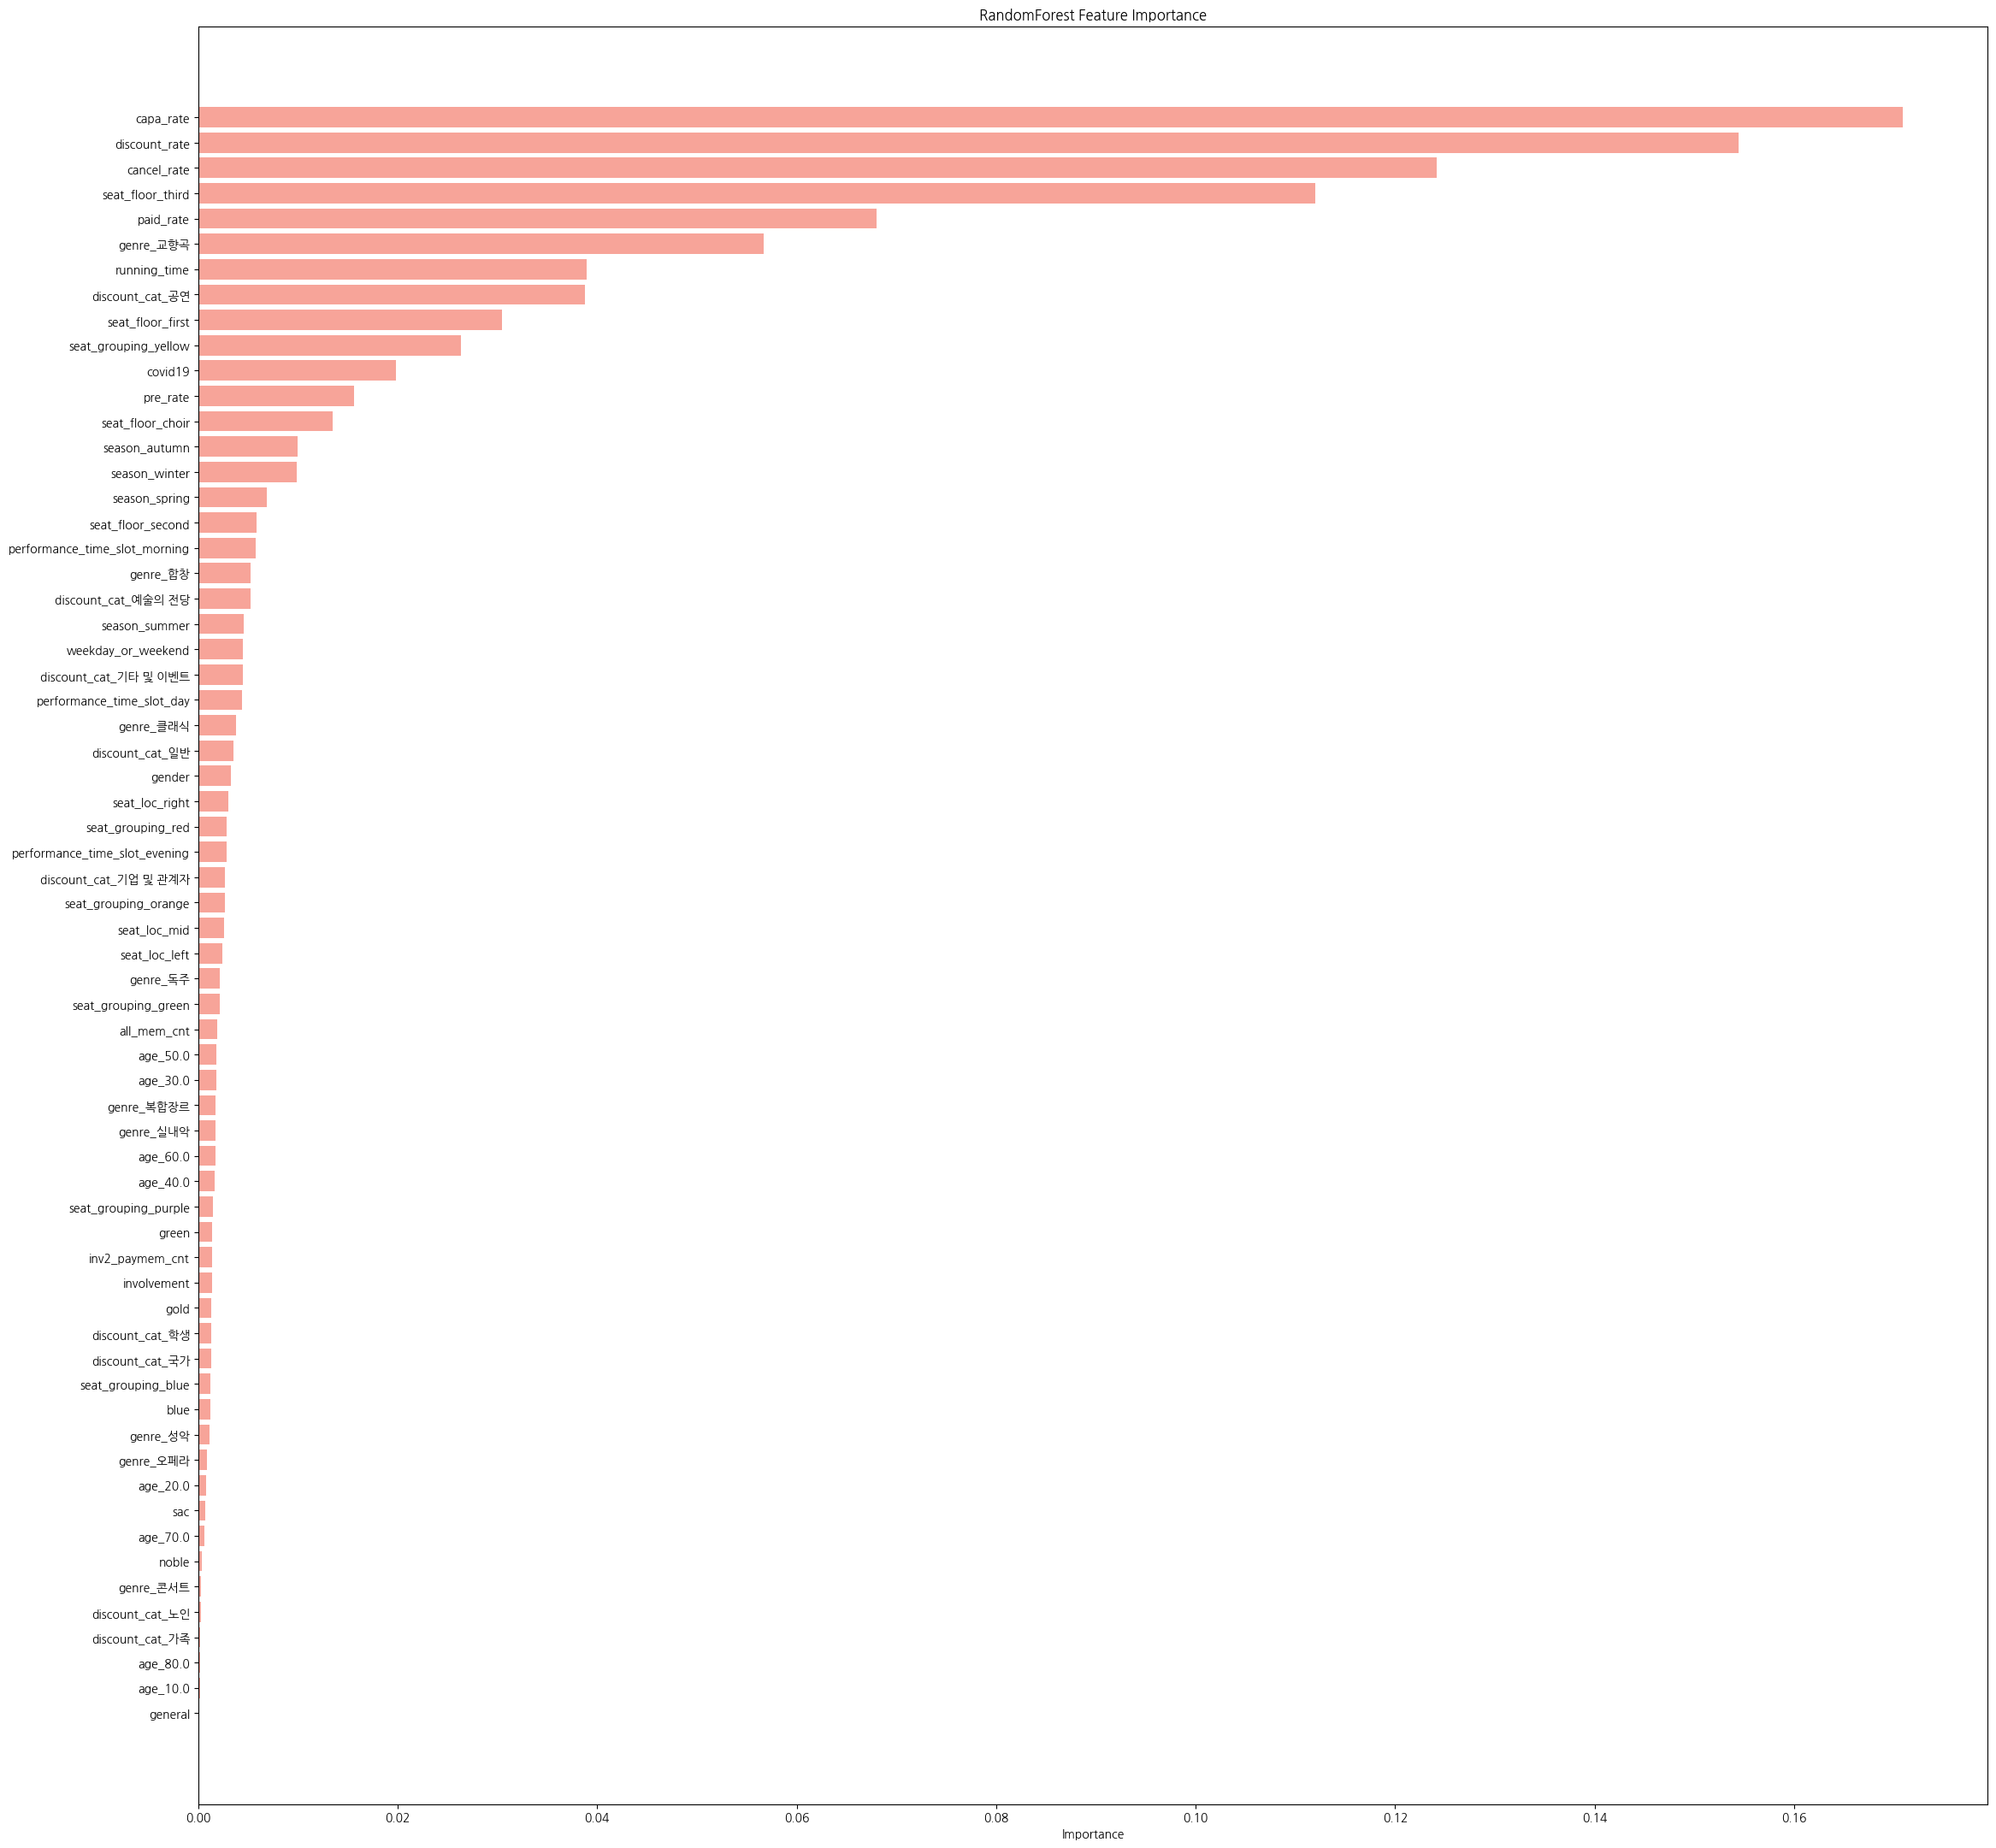

In [16]:
# 피처 중요도 추출
feature_importances = rf.feature_importances_

# 피처 이름과 함께 DataFrame 생성
features = pd.DataFrame({
    'Feature': x_train.columns, 
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 피처 중요도 시각화
plt.figure(figsize=(27, 27))
plt.barh(features['Feature'], features['Importance'], color='#F7A499')
plt.xlabel('Importance')
plt.title('RandomForest Feature Importance')
plt.gca().invert_yaxis()
plt.show()

### RandomForest SHAP Value

In [19]:
# # SHAP explainer 객체 생성
# explainer = shap.Explainer(rf)

# # SHAP values 계산
# shap_values = explainer.shap_values(x_test)

# # SHAP summary plot
# shap.summary_plot(shap_values, x_test)

# # 특정 인스턴스에 대한 SHAP force plot도 확인 가능
# # 예를 들어, 첫 번째 테스트 인스턴스에 대해
# shap.force_plot(explainer.expected_value, shap_values[0,:], x_test.iloc[0,:])

## 4. LightGBM

In [17]:
# LightGBM 모델 설정
lgb_model = lgb.LGBMRegressor(
    boosting_type='gbdt',
    num_leaves=100,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=100
)

# 모델 학습
lgb_model.fit(x_train, y_train)

# 예측
predictions = lgb_model.predict(x_test)

# 잔차 계산
residuals = y_test - predictions

# 잔차의 표준편차
sigma = np.std(residuals)

# 로그 우도 계산
logL = np.sum(norm.logpdf(residuals, loc=0, scale=sigma))

# 파라미터 수 (여기서는 트리의 리프 노드 수로 간주)
k = lgb_model.n_estimators * lgb_model.num_leaves  # 전체 트리의 수 * 각 트리의 리프 노드 수

# 샘플 수
n = len(y_test)

# AIC와 BIC 계산
AIC = 2*k - 2*logL
BIC = k*np.log(n) - 2*logL

# 로그 변환된 값을 원래 스케일로 변환
original_y_test = np.exp(y_test)
original_predictions = np.exp(predictions)


# 평가 지표 출력
explained_var = explained_variance_score(original_predictions, original_y_test)
mse = mean_squared_error(original_predictions, original_y_test)

print('--------------------------------------------------------')
print(f"Training R^2 Score: {lgb_model.score(x_train, y_train):.4f}")
print(f"Explained Variance Score: {explained_var:.4f}")
print(f"Rooted Mean Squared Error: {np.sqrt(mse):.4f}")
print(f"AIC: {AIC:.4f}")
print(f"BIC: {BIC:.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 944
[LightGBM] [Info] Number of data points in the train set: 250123, number of used features: 63
[LightGBM] [Info] Start training from score 10.722618
--------------------------------------------------------
Training R^2 Score: 0.9405
Explained Variance Score: 0.4696
Rooted Mean Squared Error: 29338.9511
AIC: 106535.0771
BIC: 196426.0674


### LGBM 성능 시각화

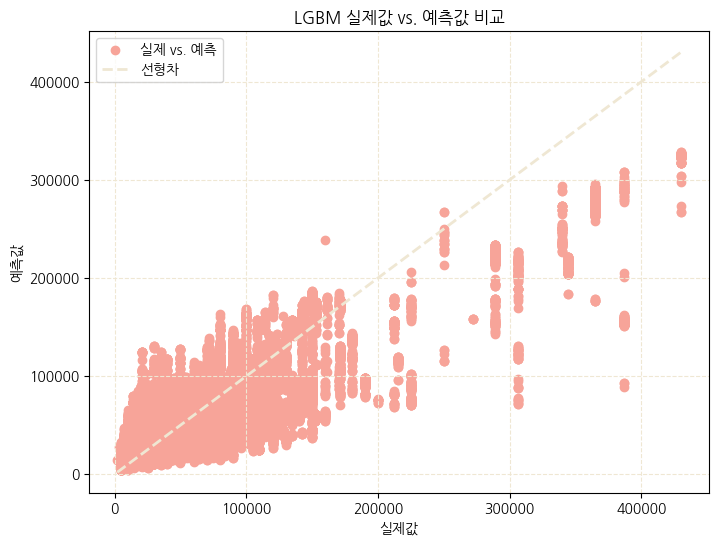

In [18]:
# 예측값 (y_pred)와 실제값 (y_true) 설정
y_true = original_y_test  # 실제값
y_pred = original_predictions  # 예측값

# 예측값과 실제값 비교 그래프를 그립니다.
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, c='#F7A499', marker='o', label='실제 vs. 예측')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('LGBM 실제값 vs. 예측값 비교')
plt.legend(loc='upper left')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], linestyle='--', color='#EFE7D3', linewidth=2, label='선형차')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', color='#EFE7D3')
plt.show()

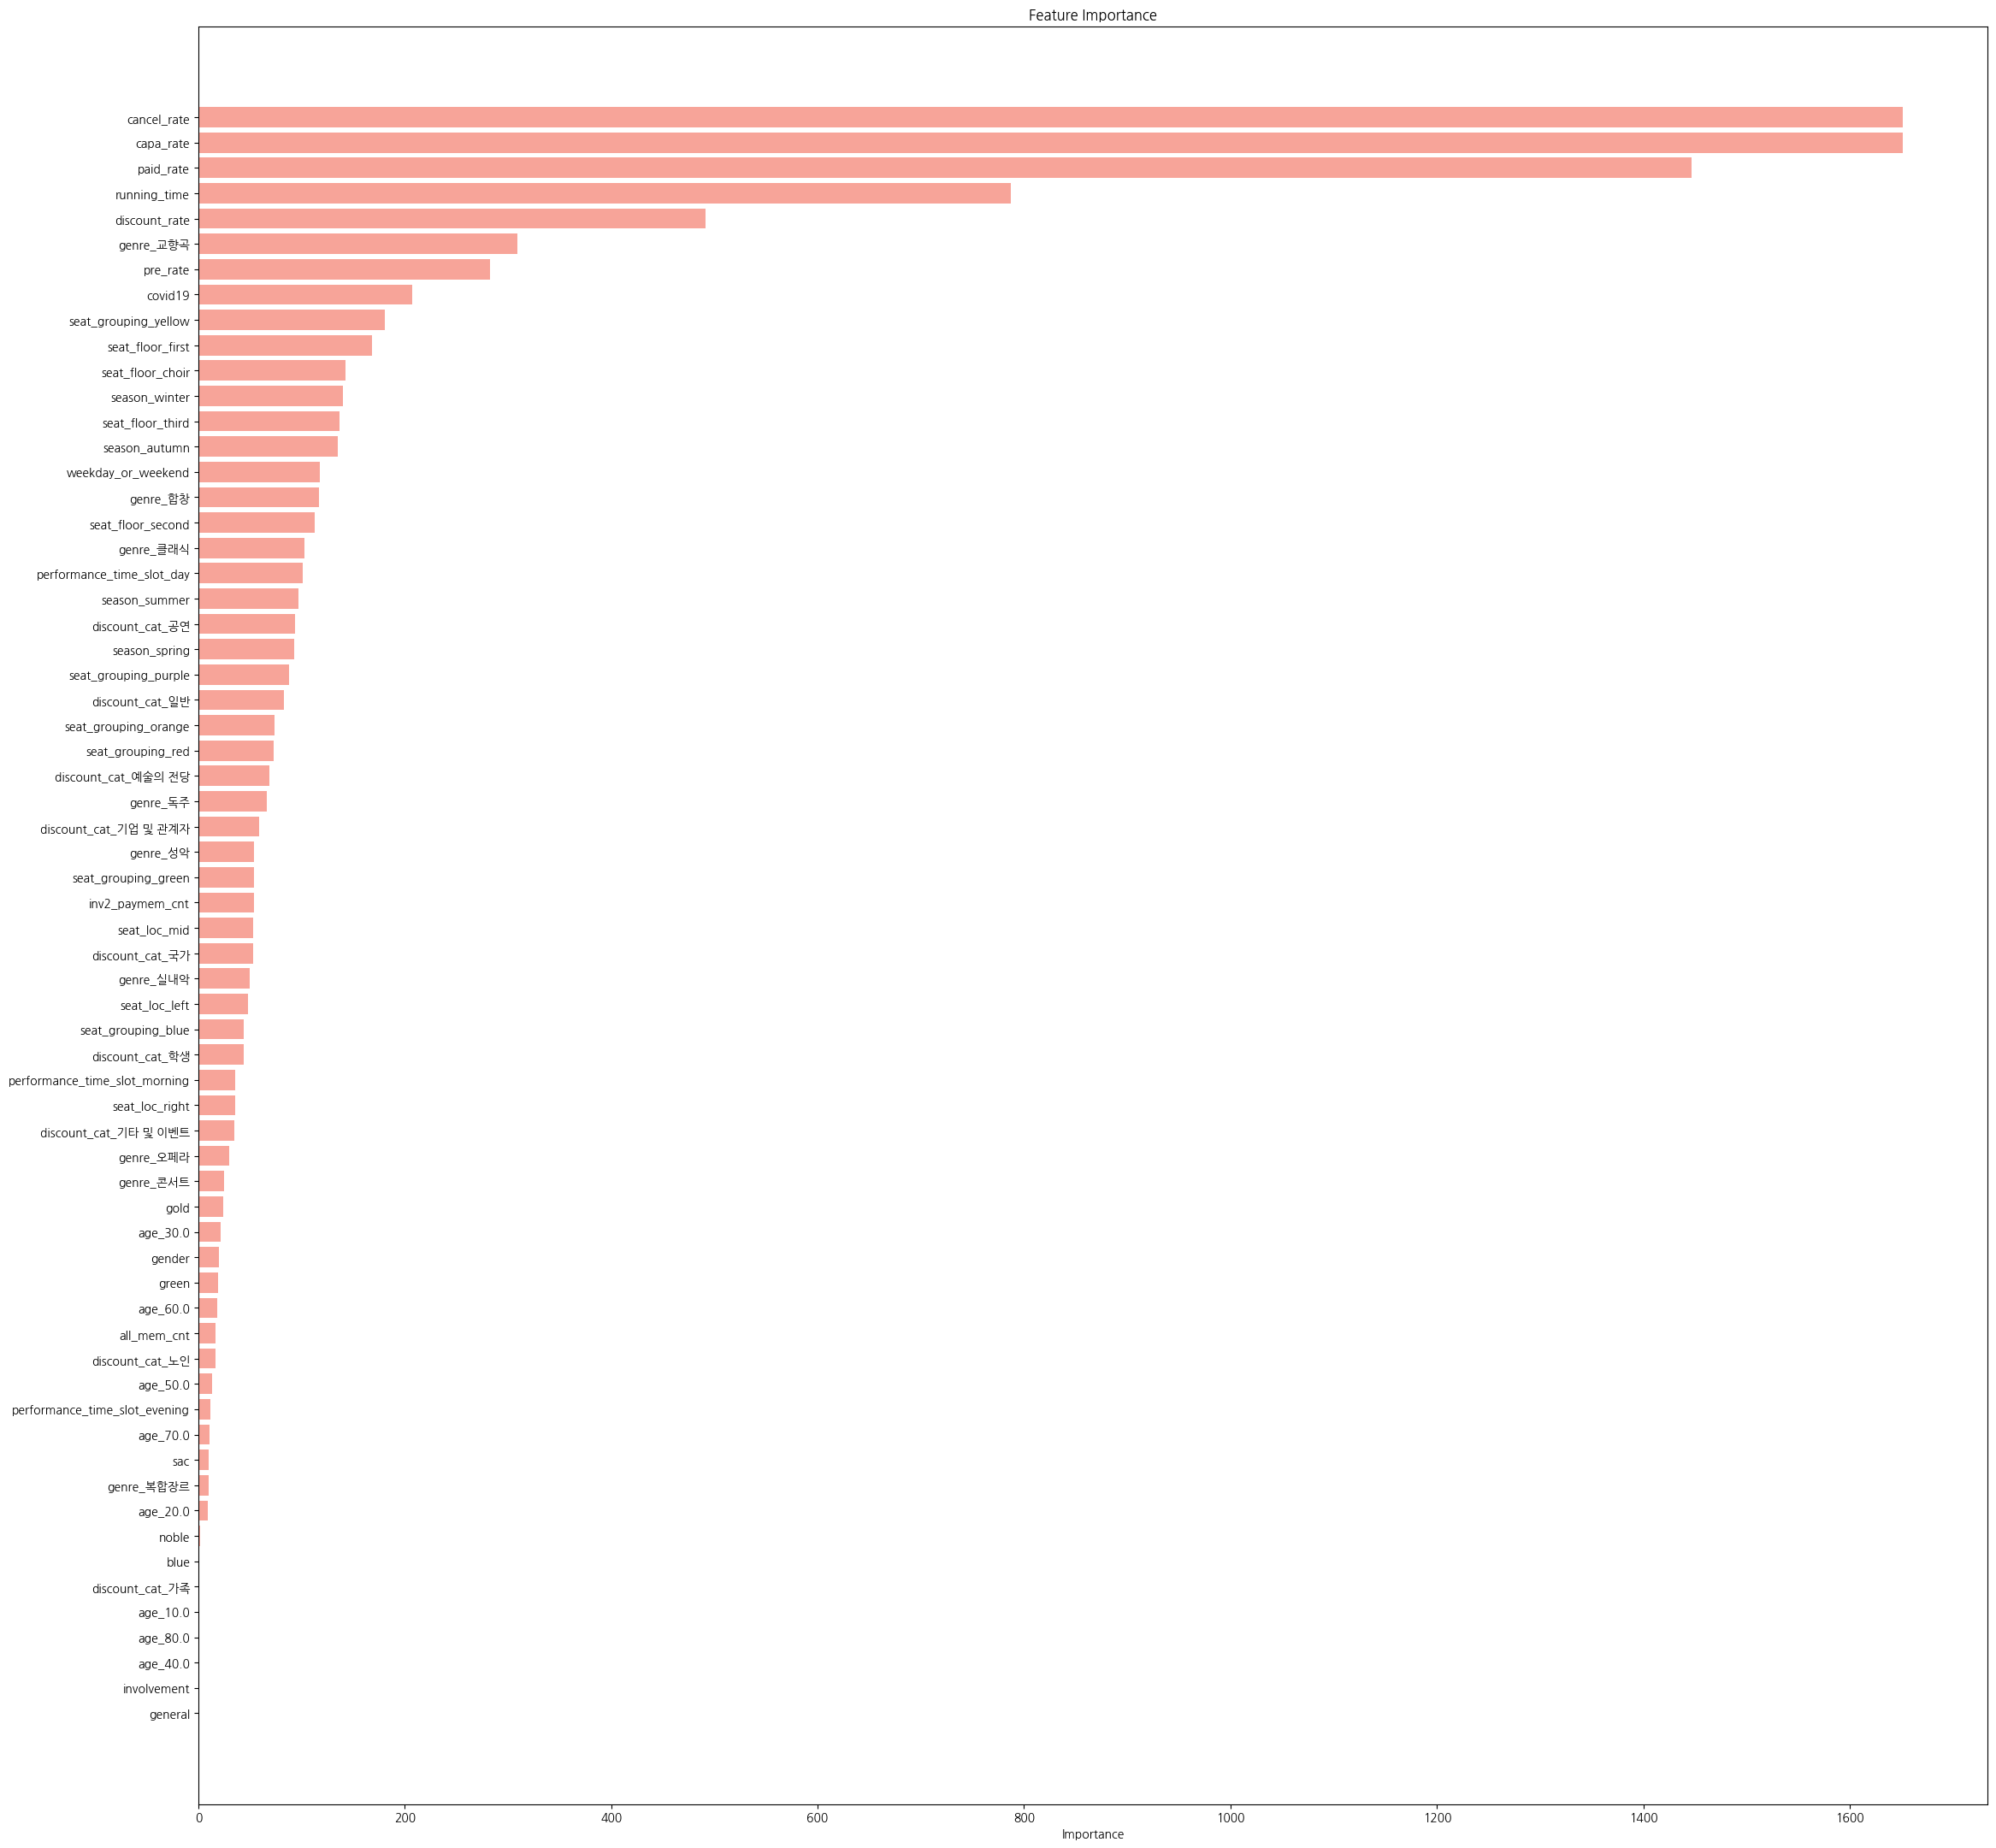

In [19]:
# 피처 중요도 추출
feature_importances = lgb_model.feature_importances_

# 피처 이름과 함께 DataFrame 생성
features = pd.DataFrame({
    'Feature': x_train.columns, 
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 피처 중요도 시각화
plt.figure(figsize=(27, 27))
plt.barh(features['Feature'], features['Importance'], color='#F7A499')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

### LGBM SHAP Value

In [ ]:
# SHAP explainer 객체 생성
explainer = shap.Explainer(lgb_model)

# SHAP values 계산
shap_values = explainer.shap_values(x_test)

# SHAP summary plot
shap.summary_plot(shap_values, x_test)

# 특정 인스턴스에 대한 SHAP force plot도 확인 가능
# 예를 들어, 첫 번째 테스트 인스턴스에 대해
shap.force_plot(explainer.expected_value, shap_values[0,:], x_test.iloc[0,:])

## 5. Decision Tree Regressor

In [20]:
# DecisionTreeRegressor 모델 설정 및 학습
dt_model = DecisionTreeRegressor(max_depth=7)
dt_model.fit(x_train, y_train)


# 예측 및 평가
dt_predictions = dt_model.predict(x_test)
# 잔차 계산
residuals = y_test - dt_predictions
# 잔차의 표준편차
sigma = np.std(residuals)
# 로그 우도 계산
logL = np.sum(norm.logpdf(residuals, loc=0, scale=sigma))
# 파라미터 수 (여기서는 트리의 리프 노드 수로 간주)
k = dt_model.get_n_leaves()
# 샘플 수
n = len(y_test)

# AIC와 BIC 계산
dt_AIC = 2*k - 2*logL
dt_BIC = k*np.log(n) - 2*logL

# 로그 변환된 값을 원래 스케일로 변환
original_y_test = np.exp(y_test)
original_predictions = np.exp(dt_predictions)

# 평가 지표 출력
dt_explained_var = explained_variance_score(original_predictions, original_y_test)
dt_mse = mean_squared_error(original_predictions, original_y_test)

print(f"Training R^2 Score: {dt_model.score(x_train, y_train):.4f}")
print(f"Explained Variance Score: {dt_explained_var:.4f}")
print(f"Rooted Mean Squared Error: {np.sqrt(dt_mse):.4f}")
print(f"AIC: {dt_AIC:.4f}")
print(f"BIC: {dt_BIC:.4f}")

Training R^2 Score: 0.6337
Explained Variance Score: 0.2280
Rooted Mean Squared Error: 36205.3228
AIC: 117321.4048
BIC: 118463.0204


### DT Regressor 성능 시각화

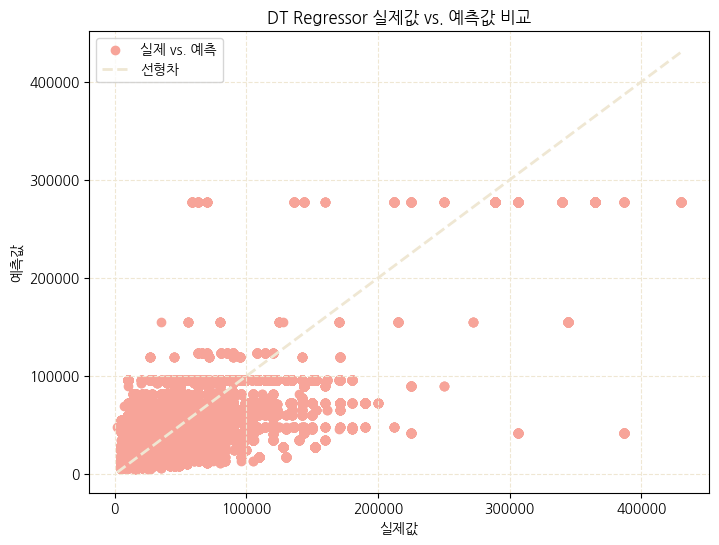

In [22]:
# 예측값 (y_pred)와 실제값 (y_true) 설정
y_true = original_y_test  # 실제값
y_pred = original_predictions  # 예측값

# 예측값과 실제값 비교 그래프를 그립니다.
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, c='#F7A499', marker='o', label='실제 vs. 예측')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('DT Regressor 실제값 vs. 예측값 비교')
plt.legend(loc='upper left')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], linestyle='--', color='#EFE7D3', linewidth=2, label='선형차')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', color='#EFE7D3')
plt.show()

### DT Regressor Feature Importance

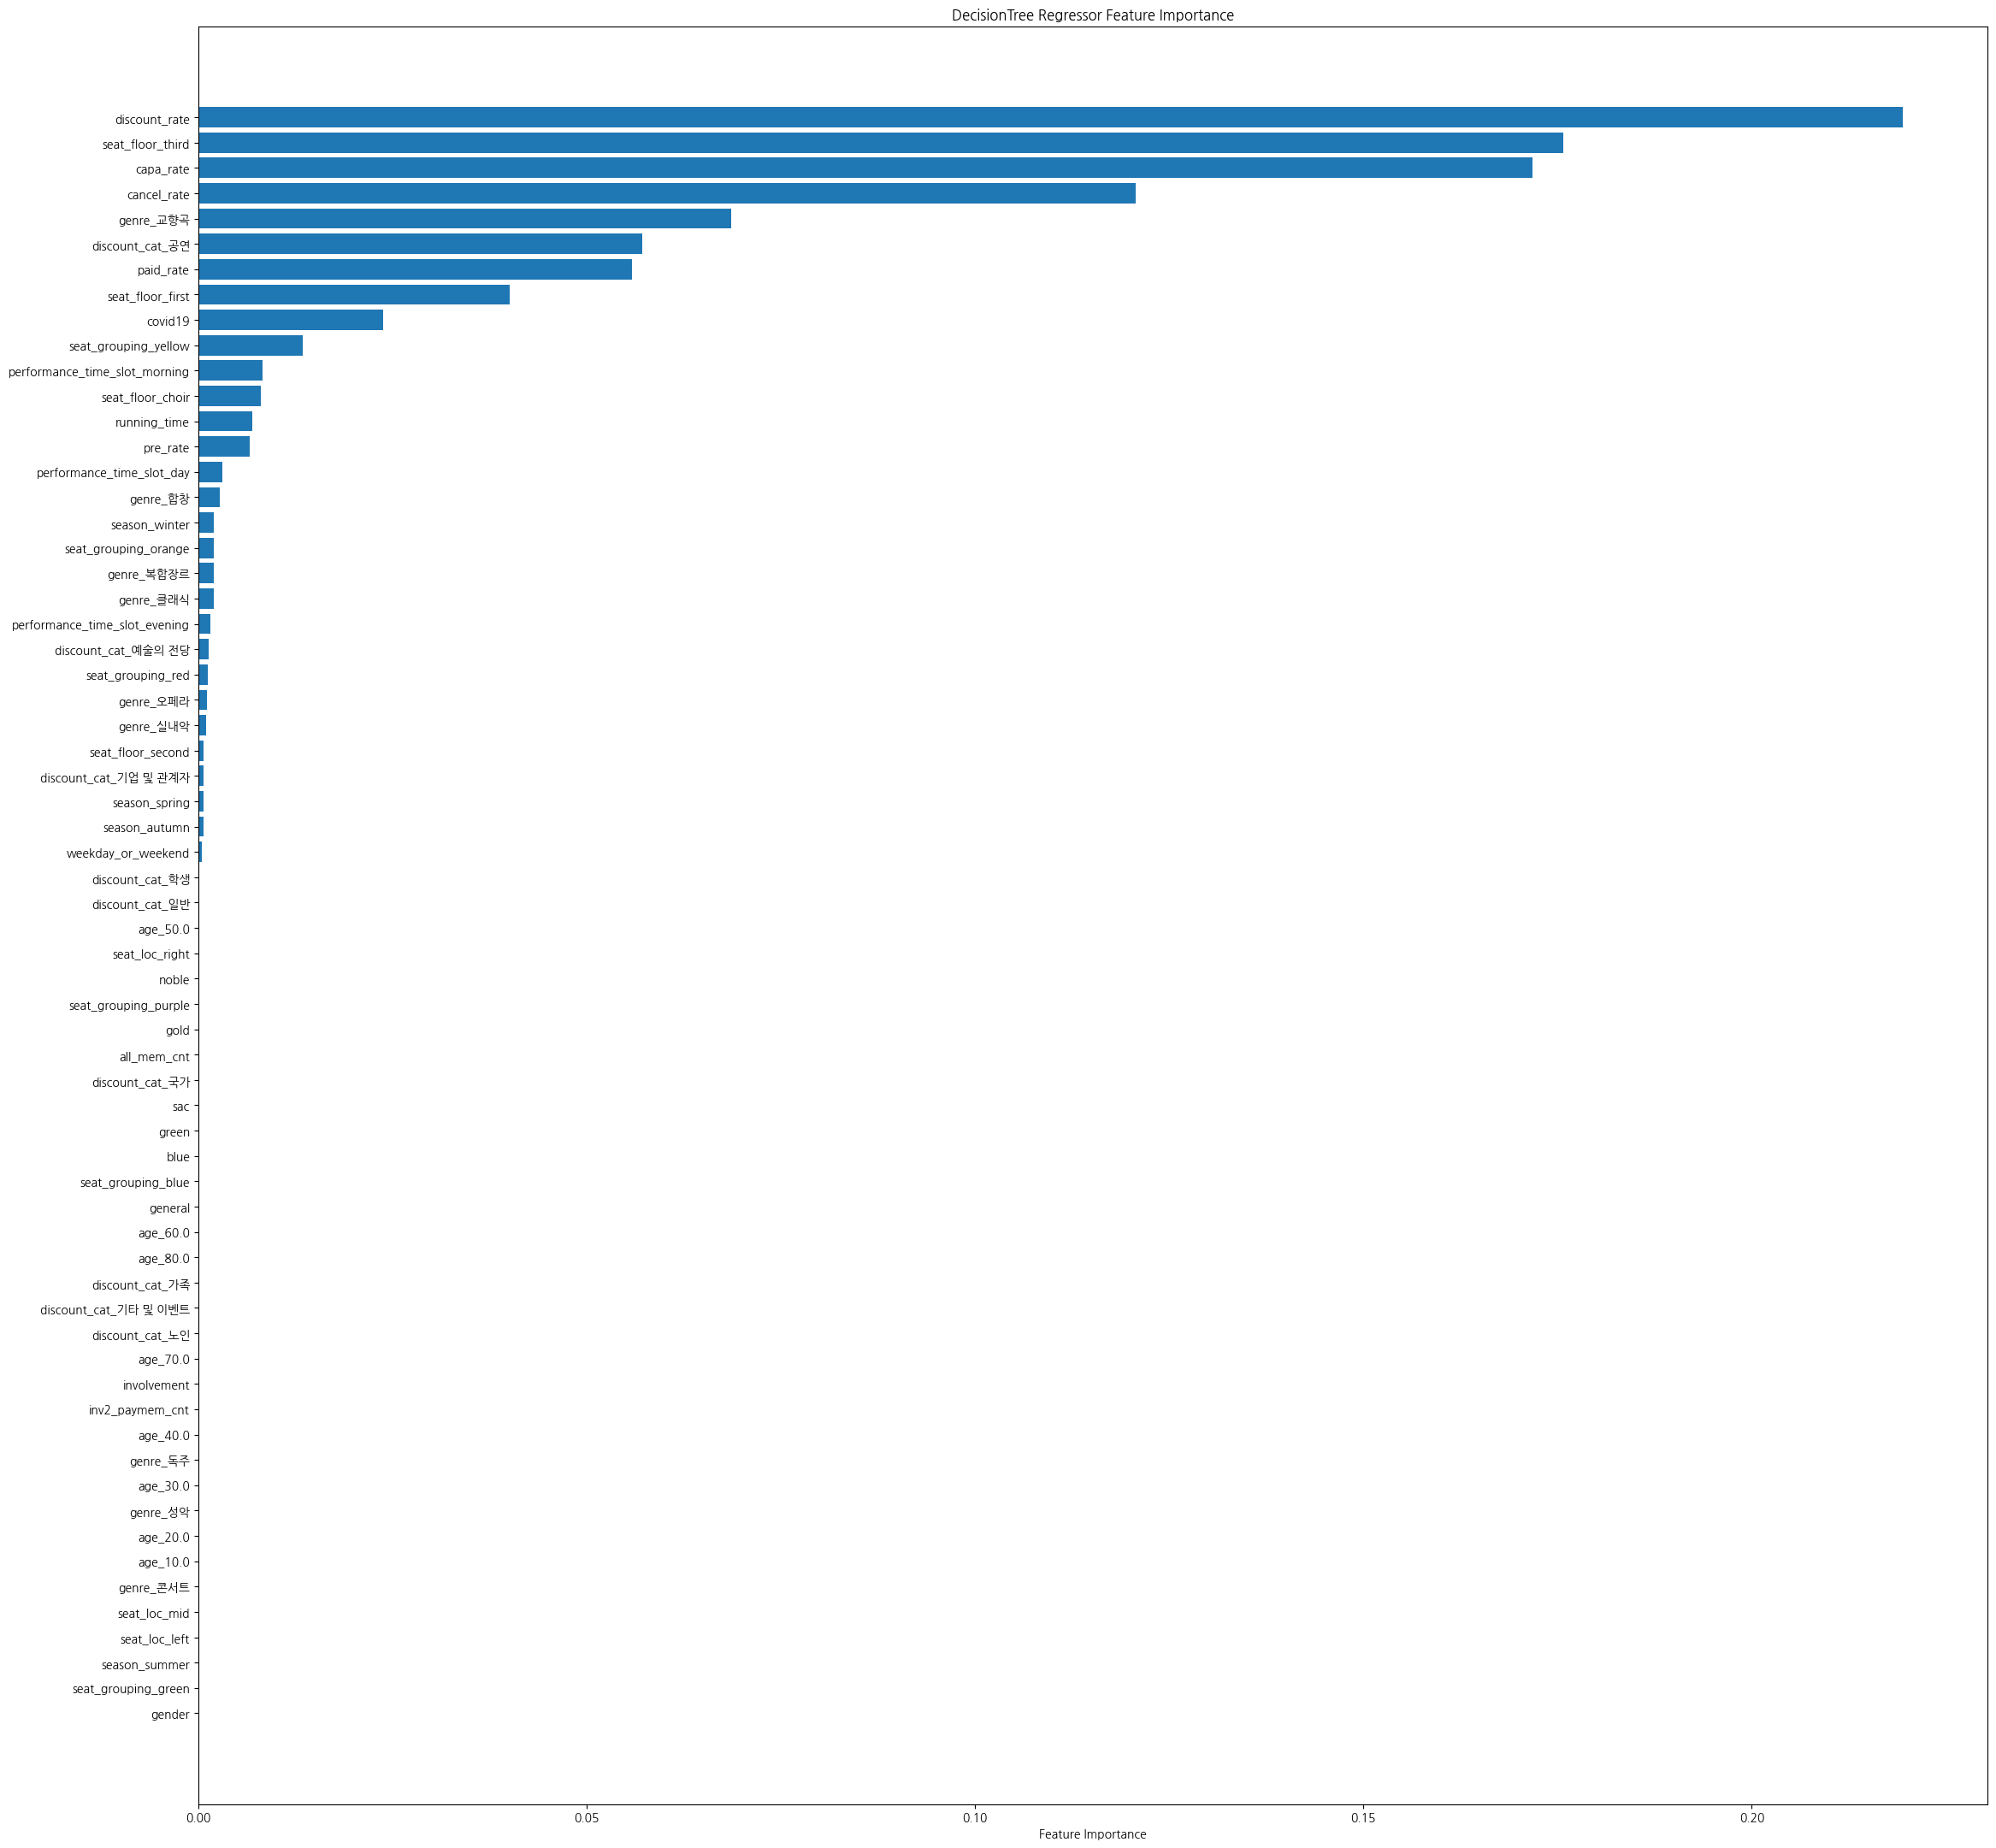

In [25]:
# 특성 중요도 가져오기
feature_importances = dt_model.feature_importances_

# 중요도에 따라 특성 정렬
sorted_idx = feature_importances.argsort()

# 특성 중요도 시각화
plt.figure(figsize=(27, 27))
plt.barh(range(test_data_grouped.drop('price', axis=1).shape[1]), feature_importances[sorted_idx])
plt.yticks(range(test_data_grouped.drop('price', axis=1).shape[1]), [test_data_grouped.drop('price', axis=1).columns[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('DecisionTree Regressor Feature Importance')
plt.show()

# 가격모델 DL

In [26]:
x_train = train_data_grouped.drop('price', axis=1).values
y_train = train_data_grouped['price'].values

x_test = test_data_grouped.drop('price', axis=1).values
y_test = test_data_grouped['price'].values


# 데이터 형태 변환 (샘플 수, 특성 수, 채널 수)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

## 1. DNN

In [70]:
## 2. DNN
# DNN 모델 설정
es = EarlyStopping(monitor='val_loss',mode='min',patience=5,verbose=1)
ms = ModelCheckpoint('dnn.h5',monitor='val_loss',patience=5)
callback_list = [es,ms]

# DNN 모델 정의
DNN_model = Sequential([
    Dense(512, input_shape=(x_train.shape[1],)),
    LeakyReLU(),
    Dense(256),
    LeakyReLU(),
    Dense(128),
    LeakyReLU(),
    Dense(64),
    LeakyReLU(),
    Dense(32),
    LeakyReLU(),
    Dense(1)
])

# 모델 컴파일
DNN_model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
DNN_model.fit(x_train, y_train, epochs=100, batch_size=16, callbacks=callback_list, validation_split=0.2)


# 예측
y_pred = DNN_model.predict(x_test)

# 잔차 (로그 스케일)
residuals_log = y_test - y_pred.reshape(-1)

# 잔차의 표준편차 (로그 스케일)
sigma_log = np.std(residuals_log)

# 로그 우도 계산 (로그 스케일)
logL_log = np.sum(norm.logpdf(residuals_log, loc=0, scale=sigma_log))

# 파라미터 수 (여기서는 모델의 가중치 수)
k = DNN_model.count_params()

# 샘플 수
n = len(y_test)

# AIC와 BIC 계산 (로그 스케일)
AIC_log = 2*k - 2*logL_log
BIC_log = k*np.log(n) - 2*logL_log

# 원래 스케일로 변환
original_y_test1 = np.exp(y_test)
original_y_pred1 = np.exp(y_pred)

# 원래 스케일에서의 평가 지표 계산
rmse_original = np.sqrt(mean_squared_error(original_y_test1, original_y_pred1))
explained_var_original = explained_variance_score(original_y_test1, original_y_pred1)

# 결과 출력 (원래 스케일과 로그 스케일)
print(f"RMSE (Original Scale): {rmse_original}")
print(f"Explained Variance Score (Original Scale): {explained_var_original}")
print(f"AIC (Log Scale): {AIC_log}")
print(f"BIC (Log Scale): {BIC_log}")


Epoch 1/100
12482/12482 [==============================] - 53s 4ms/step - loss: 0.8495 - val_loss: 0.6538
Epoch 2/100
12482/12482 [==============================] - 50s 4ms/step - loss: 0.6216 - val_loss: 0.5833
Epoch 3/100
12482/12482 [==============================] - 51s 4ms/step - loss: 0.5734 - val_loss: 0.5715
Epoch 4/100
12482/12482 [==============================] - 51s 4ms/step - loss: 0.5420 - val_loss: 0.5456
Epoch 5/100
12482/12482 [==============================] - 52s 4ms/step - loss: 0.5230 - val_loss: 0.5342
Epoch 6/100
12482/12482 [==============================] - 51s 4ms/step - loss: 0.5090 - val_loss: 0.5764
Epoch 7/100
12482/12482 [==============================] - 50s 4ms/step - loss: 0.4982 - val_loss: 0.4857
Epoch 8/100
12482/12482 [==============================] - 52s 4ms/step - loss: 0.4927 - val_loss: 0.5547
Epoch 9/100
12482/12482 [==============================] - 52s 4ms/step - loss: 0.4869 - val_loss: 0.5799
Epoch 10/100
12482/12482 [====================

### DNN 성능 시각화

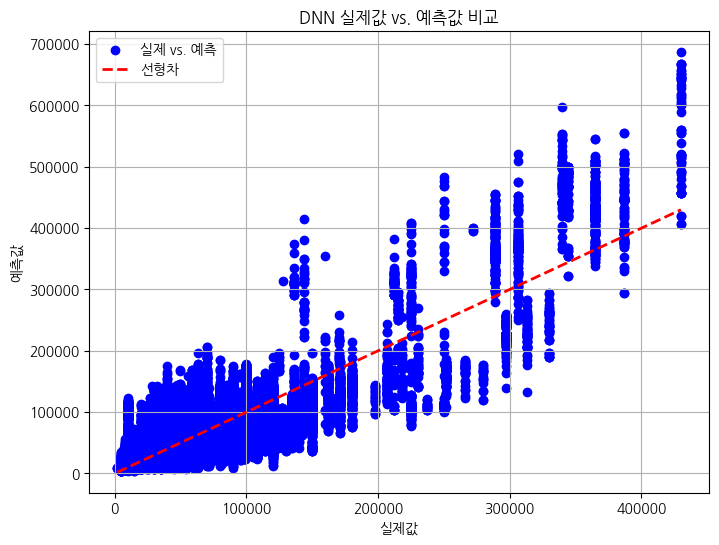

In [ ]:
# 예측값 (y_pred)와 실제값 (y_true) 설정
y_true = original_y_test1  # 실제값
y_pred = original_y_pred1  # 예측값

# 예측값과 실제값 비교 그래프를 그립니다.
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, c='blue', marker='o', label='실제 vs. 예측')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('DNN 실제값 vs. 예측값 비교')
plt.legend(loc='upper left')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], linestyle='--', color='red', linewidth=2, label='선형차')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

### DNN Feature Importance

1902/1902 [==============================] - 2s 1ms/step


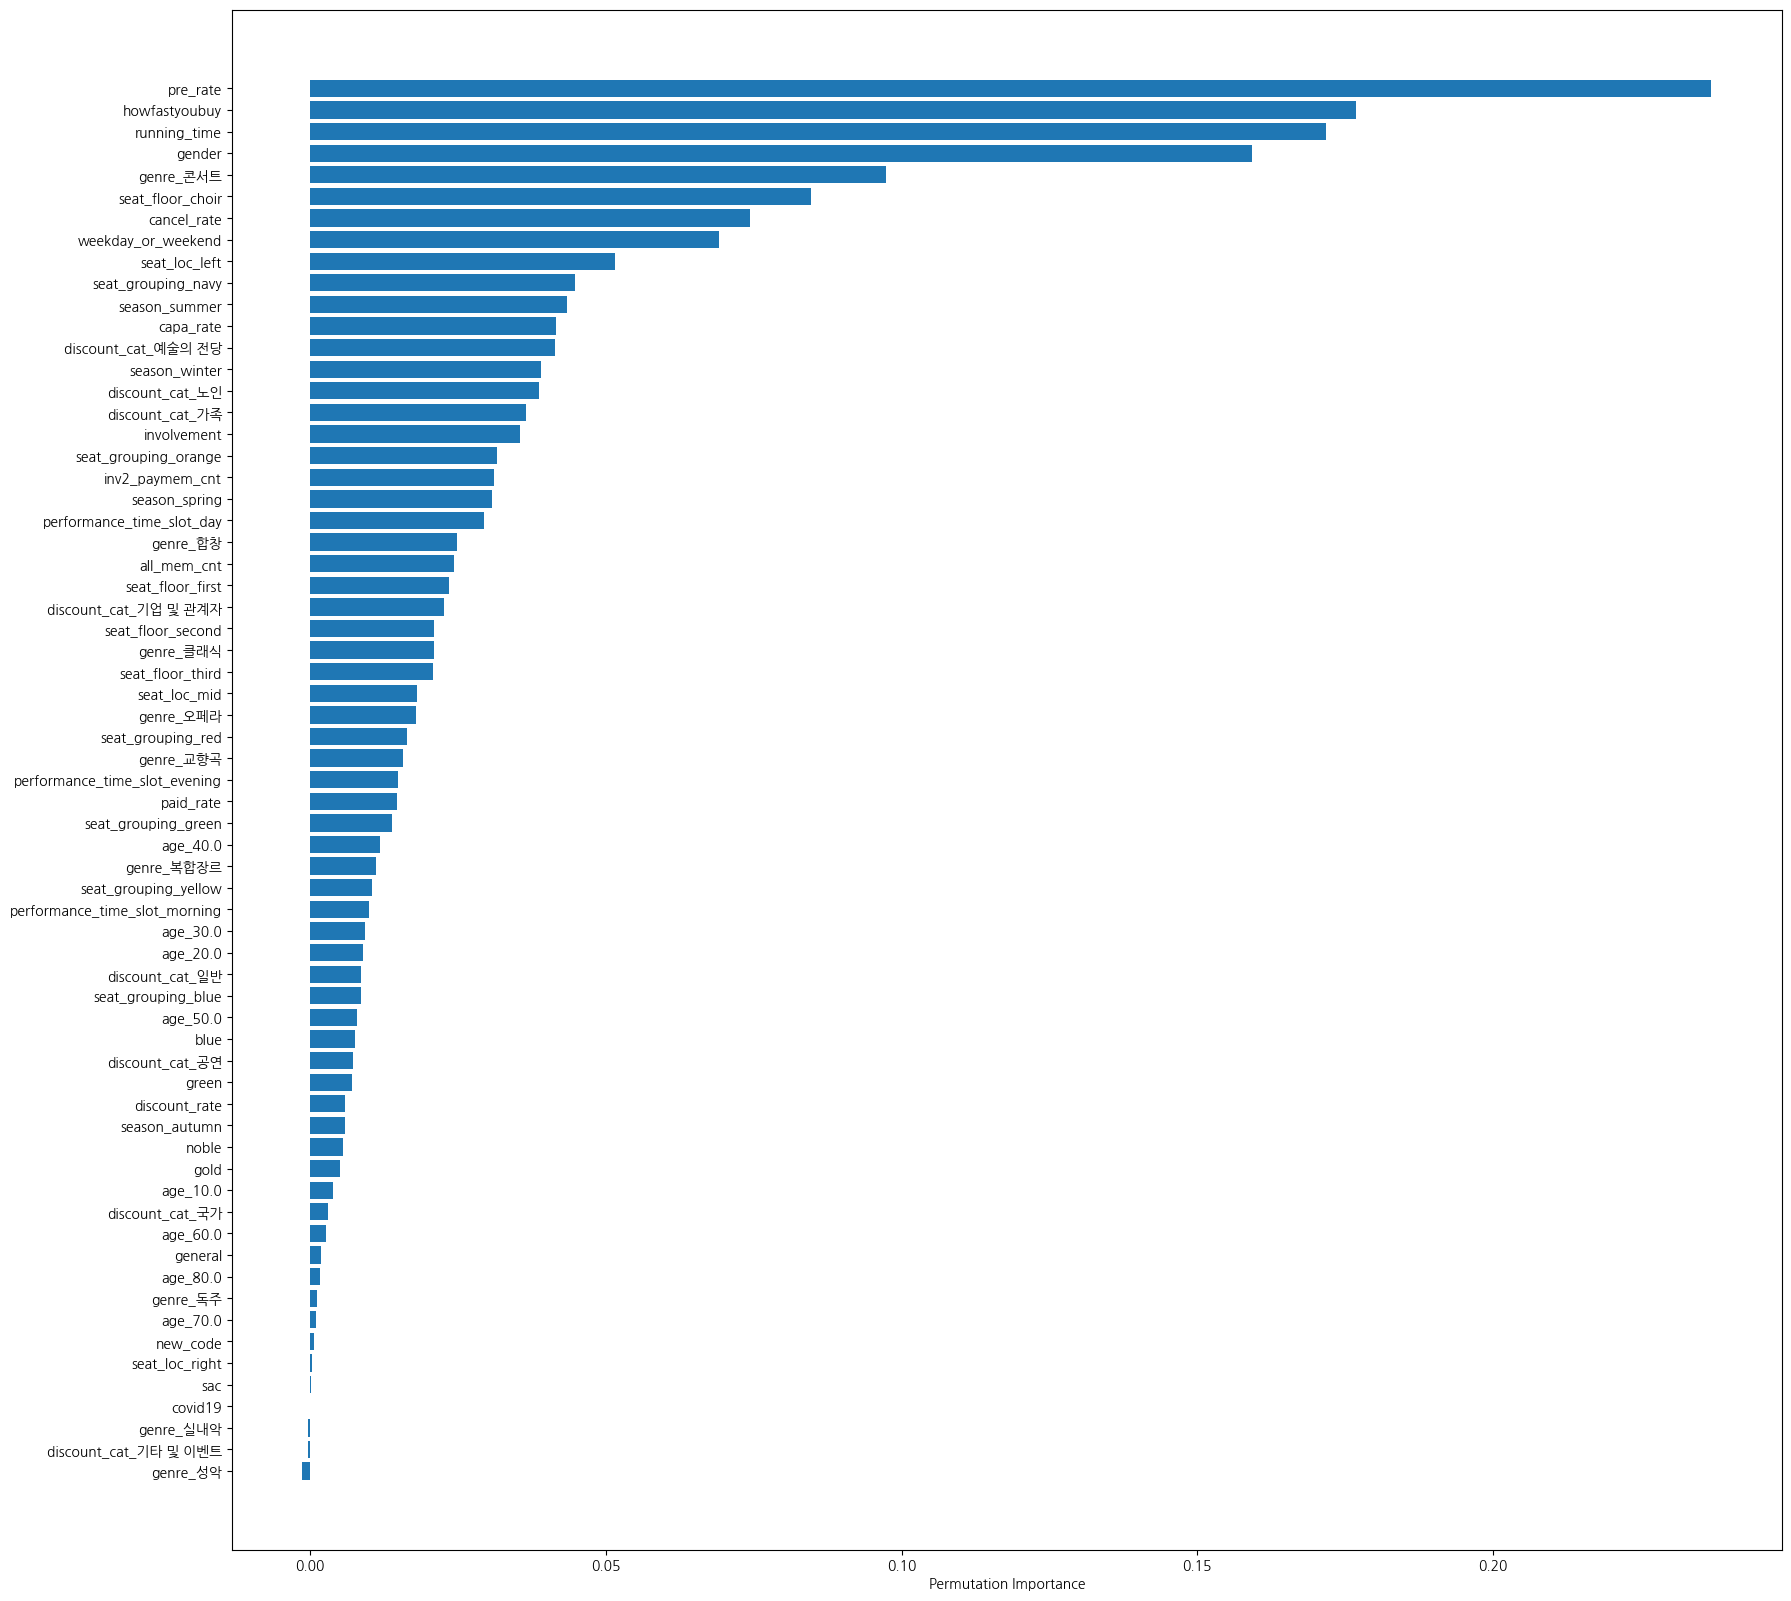

In [ ]:
def calculate_permutation_importance(model, X_test, y_test, feature_names):
    base_error = mean_squared_error(y_test, model.predict(X_test))
    perm_importance = np.zeros(X_test.shape[1])

    for i in range(X_test.shape[1]):
        shuffled_idx = np.random.permutation(X_test.shape[0])
        X_shuffled = X_test.copy()
        X_shuffled[:, i] = X_test[shuffled_idx, i]
        shuff_error = mean_squared_error(y_test, model.predict(X_shuffled))
        perm_importance[i] = shuff_error - base_error

    return perm_importance

# Assuming df_encoded is your original dataframe and 'price' is the target column
feature_names = df_encoded.drop('price', axis=1).columns.tolist()

# Flatten the 3D array to 2D for Permutation Importance
X_test_flattened = x_test.reshape(x_test.shape[0], -1)

perm_importance = calculate_permutation_importance(DNN_model, X_test_flattened, y_test, feature_names)

sorted_idx = perm_importance.argsort()


plt.figure(figsize=(20, 20))
plt.barh(range(X_test_flattened.shape[1]), perm_importance[sorted_idx])
plt.yticks(range(X_test_flattened.shape[1]), [feature_names[i] for i in sorted_idx])
plt.xlabel('Permutation Importance')
plt.show()
